## 00 – Setup

In [48]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Folder containing the CSV files
data_folder = "qualitative data"  # Change to your folder name if different

# Find all CSV files in the folder
file_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(".csv")]

# Load and concatenate all CSV files
dfs = []
for path in file_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        dfs.append(df)
    else:
        print(f"File not found: {path}")

# Combine all data
df = pd.concat(dfs, ignore_index=True)

# Filter out ignored personas
ignore_personas = []
df = df[~df['persona_id'].isin(ignore_personas)]

# Remove rows where prompt_style contains 'cot' but cot_output is missing or empty
df = df[~(df['prompt_style'].str.contains("cot", case=False, na=False) & 
          (df['cot_output'].isna() | df['cot_output'].str.strip().eq('')))]

# Add numeric column for is_correct
df['is_correct_numeric'] = df['is_correct'].map({'Yes': 1.0, 'No': 0.0}) * 100


# Pretty labels for prompt styles
pretty_prompt_labels = {
    'base': 'Base',
    'persona': 'Persona',
    'examples': 'Few-Shot',
    'examples_with_cot': 'Few-Shot with CoT',
    'persona+examples': 'Persona + Few-Shot',
    'persona+examples_with_cot': 'Persona + Few-Shot with CoT'
}

# Pretty labels for model names
pretty_model_labels = {
    'gpt-4o-mini': 'GPT 4o Mini',
    'gpt-4o-2024-11-20': 'GPT 4o',
    'gpt-4.1-2025-04-14': 'GPT 4.1',
    'gpt-4.1-mini-2025-04-14': 'GPT 4.1 Mini',
    'o3-mini': 'o3 Mini',
    'o3': 'o3',
    'claude-3-7-sonnet-20250219': 'Claude 3.7 Sonnet',
    'claude-3-5-haiku-20241022': 'Claude 3.5 Haiku',
    'grok-3-beta': 'Grok 3 Beta',
    'grok-3-mini-beta': 'Grok 3 Mini Beta',
    'gemini-2.0-flash': 'Gemini 2.0 Flash',
    'gemini-2.0-flash-lite' : 'Gemini 2.0 Flash Lite',
    'gemini-2.5-pro-preview-03-25': 'Gemini 2.5 Pro',
    'deepseek-chat': 'DeepSeek Chat',
    'deepseek-reasoner': 'Deepseek Reasoner'
}


plt.rcParams.update({
    "font.size": 12,              # Base text size
    "axes.titlesize": 16,         # Title size
    "axes.labelsize": 14,         # Axis label size
    "xtick.labelsize": 12,        # X tick label size
    "ytick.labelsize": 12,        # Y tick label size
    "legend.fontsize": 12,        # Legend text
    "figure.titlesize": 16        # Figure title size
})


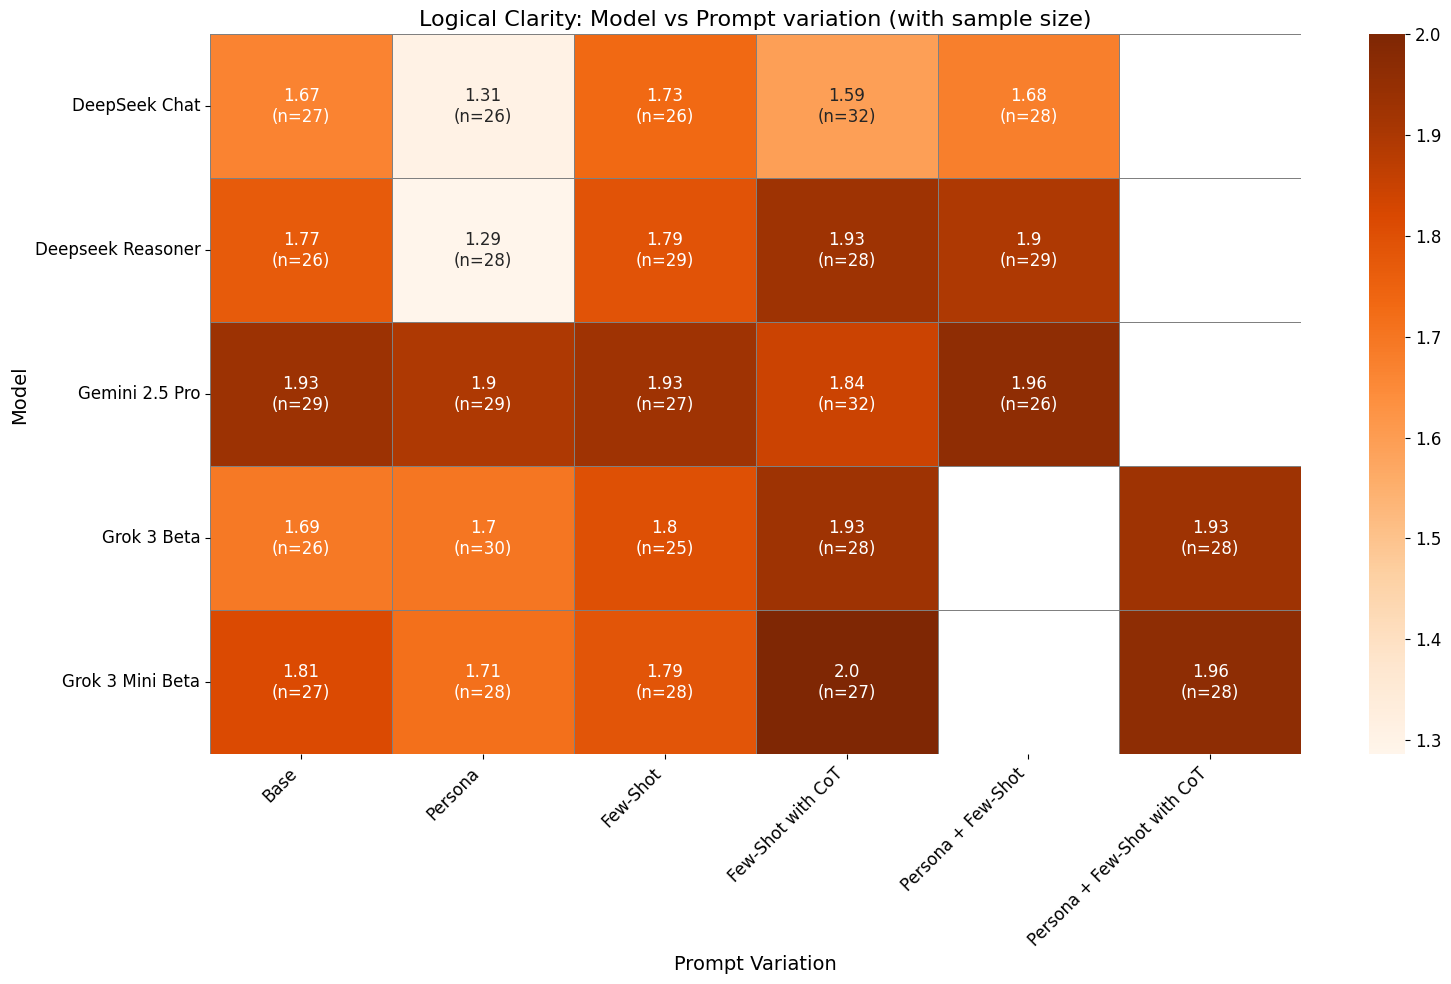

In [49]:
# Create pivot tables
mean_df = df.pivot_table(
    index='model',
    columns='prompt_style',
    values='logical_clarity',
    aggfunc='mean'
)

count_df = df.pivot_table(
    index='model',
    columns='prompt_style',
    values='logical_clarity',
    aggfunc='count'
)

# Reorder columns if needed
prompt_order = ['base', 'persona', 'examples', 'examples_with_cot',
                'persona+examples', 'persona+examples_with_cot']
prompt_order = [col for col in prompt_order if col in mean_df.columns]

mean_df = mean_df[prompt_order]
count_df = count_df[prompt_order]

# Apply pretty names
mean_df_pretty = mean_df.rename(index=pretty_model_labels, columns=pretty_prompt_labels)
count_df_pretty = count_df.rename(index=pretty_model_labels, columns=pretty_prompt_labels)

# Build annotation matrix
annot = mean_df_pretty.round(2).astype(str) + "\n(n=" + count_df_pretty.fillna(0).astype(int).astype(str) + ")"

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(mean_df_pretty, annot=annot, fmt='', cmap="Oranges", linewidths=0.5, linecolor='gray')
plt.title('Logical Clarity: Model vs Prompt variation (with sample size)')
plt.ylabel('Model')
plt.yticks(rotation=0)
plt.xlabel('Prompt Variation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


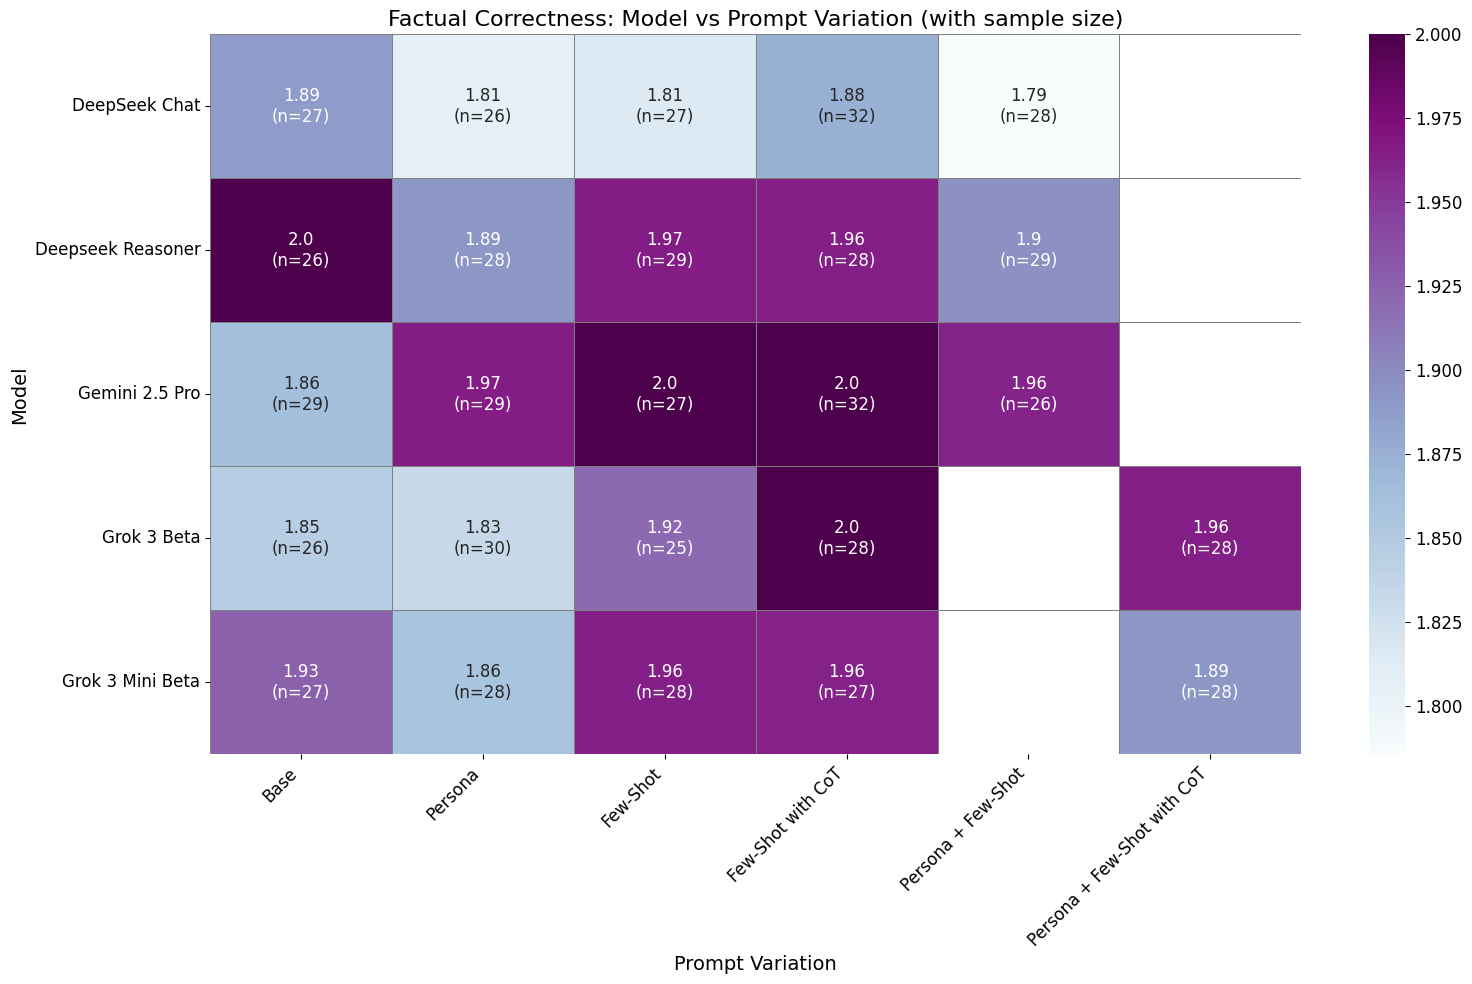

In [50]:
# Create pivot tables
mean_df = df.pivot_table(
    index='model',
    columns='prompt_style',
    values='factual_correctness',
    aggfunc='mean'
)

count_df = df.pivot_table(
    index='model',
    columns='prompt_style',
    values='factual_correctness',
    aggfunc='count'
)

# Reorder columns if needed
prompt_order = ['base', 'persona', 'examples', 'examples_with_cot',
                'persona+examples', 'persona+examples_with_cot']
prompt_order = [col for col in prompt_order if col in mean_df.columns]

mean_df = mean_df[prompt_order]
count_df = count_df[prompt_order]

# Apply pretty labels to both axes
mean_df_pretty = mean_df.rename(index=pretty_model_labels, columns=pretty_prompt_labels)
count_df_pretty = count_df.rename(index=pretty_model_labels, columns=pretty_prompt_labels)

# Build annotation matrix
annot = mean_df_pretty.round(2).astype(str) + "\n(n=" + count_df_pretty.fillna(0).astype(int).astype(str) + ")"

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(mean_df_pretty, annot=annot, fmt='', cmap="BuPu", linewidths=0.5, linecolor='gray')
plt.title('Factual Correctness: Model vs Prompt Variation (with sample size)')
plt.ylabel('Model')
plt.yticks(rotation=0)
plt.xlabel('Prompt Variation')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


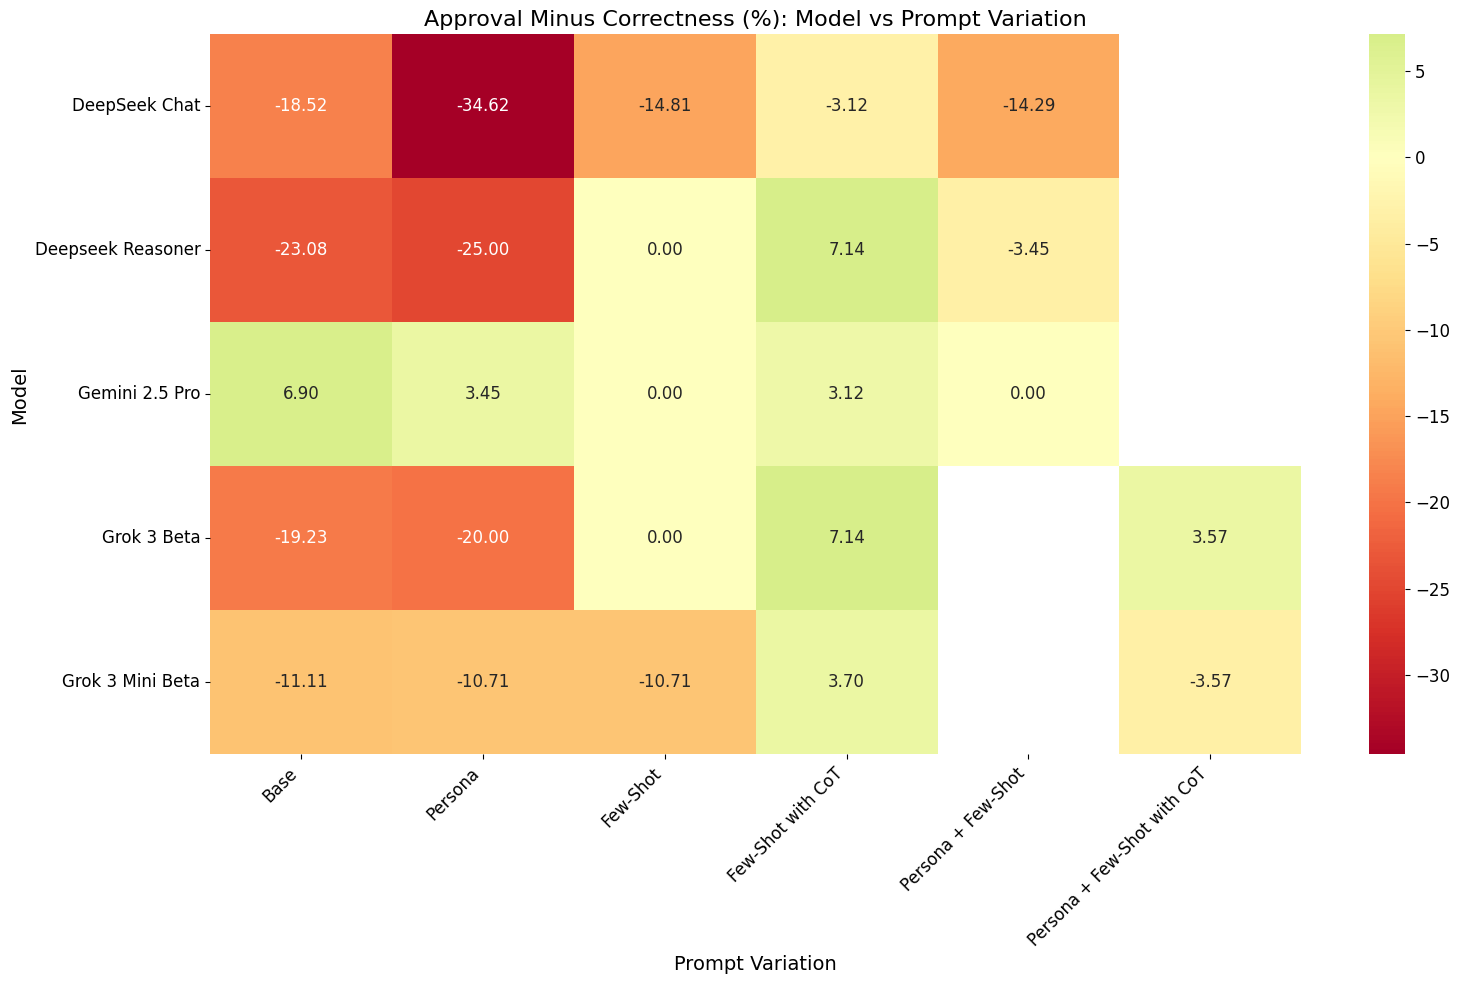

In [51]:
# Group and calculate
heatmap_data = df.groupby(['model', 'prompt_style']).agg({
    'is_correct_numeric': 'mean',
    'approved_recommendation': lambda x: (x == 'Yes').mean() * 100
}).reset_index()

# Compute difference
heatmap_data['approval_minus_correct'] = heatmap_data['approved_recommendation'] - heatmap_data['is_correct_numeric']

# Pivot table
pivot_approval_minus_correct = heatmap_data.pivot(index='model', columns='prompt_style', values='approval_minus_correct')

# Sort models alphabetically
pivot_approval_minus_correct = pivot_approval_minus_correct.sort_index()

# Reorder prompt styles
prompt_order = ['base', 'persona', 'examples', 'examples_with_cot', 'persona+examples', 'persona+examples_with_cot']
prompt_order = [col for col in prompt_order if col in pivot_approval_minus_correct.columns]
pivot_approval_minus_correct = pivot_approval_minus_correct[prompt_order]

# Rename for plot
pivot_pretty = pivot_approval_minus_correct.rename(index=pretty_model_labels, columns=pretty_prompt_labels)

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_pretty, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title('Approval Minus Correctness (%): Model vs Prompt Variation')
plt.ylabel('Model')
plt.xlabel('Prompt Variation')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [52]:
# Choose the column that contains the explanation text
# Replace 'explanation' with the actual column name if it's different
explanation_col = 'explanation' if 'explanation' in df.columns else 'cot_output'

# Drop rows with missing or empty explanations
explanations = df[explanation_col].dropna().astype(str)
explanations = explanations[explanations.str.strip() != ""]

# Count number of reviewed explanations and total words
num_explanations = len(explanations)
total_words = explanations.str.split().str.len().sum()

print(f"Number of explanations reviewed: {num_explanations}")
print(f"Total number of words in explanations: {total_words}")


Number of explanations reviewed: 698
Total number of words in explanations: 127238
